SEIR: R₀ = 4.41
SIR:  R₀ = 4.41


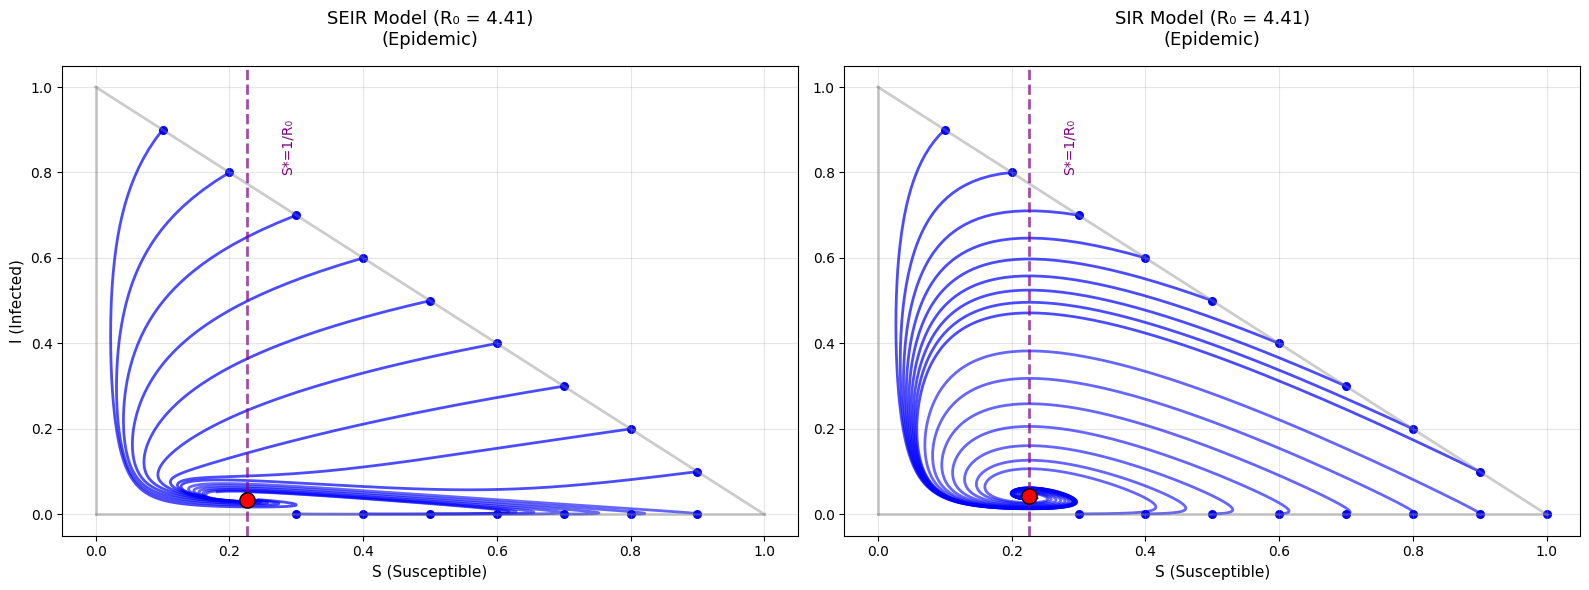

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Model functions from your notebook
def sir_demography_ivp(t, y, beta, gamma, mu):
    """SIR model with births and deaths"""
    S, I, R = y
    dSdt = mu - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

def seir_model_ivp(t, y, beta, gamma, mu, sigma):
    """SEIR model with demographics"""
    S, E, I, R = y
    dSdt = mu - beta * S * I - mu * S 
    dEdt = beta * S * I - (mu + sigma) * E
    dIdt = sigma * E - (mu + gamma) * I
    dRdt = gamma * I - mu * R
    return [dSdt, dEdt, dIdt, dRdt]

def solve_epidemic_model(model_func, initial_conditions, t_span, args, method='RK45'):
    """Generic epidemic model solver"""
    if isinstance(t_span, (list, tuple)) and len(t_span) == 2:
        t_eval = np.linspace(t_span[0], t_span[1], 1000)
    else:
        t_eval = t_span
        t_span = [t_span[0], t_span[-1]]
    
    sol = solve_ivp(model_func, t_span, initial_conditions,
                    t_eval=t_eval, args=args, method=method,
                    rtol=1e-8, atol=1e-10)
    return sol.t, sol.y.T

def calculate_R0_seir(beta, gamma, mu, sigma):
    """Calculate R0 for SEIR model"""
    return (beta * sigma) / ((mu + sigma) * (mu + gamma))

def calculate_R0_sir(beta, gamma, mu):
    """Calculate R0 for SIR model"""
    return beta / (gamma + mu)

def plot_phase_portrait_seir_sir():
    """Plot SEIR vs SIR phase portraits using your exact code structure"""
    # Parameters - matching your SEIR time series with R0 = 4.41
    beta_seir = 1.5
    gamma = 0.25
    mu = 1/70
    sigma = 0.05
    
    # Calculate R0 and find equivalent SIR beta
    R0_seir = calculate_R0_seir(beta_seir, gamma, mu, sigma)
    beta_sir = R0_seir * (gamma + mu)  # Adjust SIR beta to match R0
    R0_sir = calculate_R0_sir(beta_sir, gamma, mu)
    
    print(f"SEIR: R₀ = {R0_seir:.2f}")
    print(f"SIR:  R₀ = {R0_sir:.2f}")
    
    # Time parameters
    t_max = 100
    
    # Create figure with 2 subplots (exactly like your phase portrait functions)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Initial condition variations (exactly like your notebook)
    S0_list = np.linspace(0.1, 1.0, 10)
    
    # SEIR phase portrait (left subplot)
    for S0_var in S0_list:
        # High infection trajectory
        I0_var = 1 - S0_var
        E0_var = 0.001  # Small exposed population
        R0_var = 0
        
        if I0_var > 0:
            t, result = solve_epidemic_model(seir_model_ivp, 
                                           [S0_var, E0_var, I0_var, R0_var],
                                           [0, t_max], (beta_seir, gamma, mu, sigma))
            axes[0].plot(result[:, 0], result[:, 2], 'blue', alpha=0.7, linewidth=2)
            axes[0].scatter(S0_var, I0_var, c='blue', s=30)
        
        # Low infection trajectory (if epidemic possible)
        if S0_var > 1/R0_seir and R0_seir > 1:
            I0_small = 0.001
            E0_small = 0.001
            R0_small = 1 - I0_small - E0_small - S0_var
            if R0_small >= 0:
                t, result = solve_epidemic_model(seir_model_ivp,
                                               [S0_var, E0_small, I0_small, R0_small],
                                               [0, t_max], (beta_seir, gamma, mu, sigma))
                axes[0].plot(result[:, 0], result[:, 2], 'b-', alpha=0.6, linewidth=2)
                axes[0].scatter(S0_var, I0_small, c='blue', s=30)
    
    # SIR phase portrait (right subplot)
    for S0_var in S0_list:
        # High infection trajectory
        I0_var = 1 - S0_var
        R0_var = 0
        
        t, result = solve_epidemic_model(sir_demography_ivp, 
                                       [S0_var, I0_var, R0_var],
                                       [0, t_max], (beta_sir, gamma, mu))
        axes[1].plot(result[:, 0], result[:, 1], 'blue', alpha=0.7, linewidth=2)
        axes[1].scatter(S0_var, I0_var, c='blue', s=30)
        
        # Low infection trajectory (if epidemic possible)
        if S0_var > 1/R0_sir and R0_sir > 1:
            I0_small = 0.001
            R0_small = 1 - I0_small - S0_var
            if R0_small >= 0:
                t, result = solve_epidemic_model(sir_demography_ivp,
                                               [S0_var, I0_small, R0_small],
                                               [0, t_max], (beta_sir, gamma, mu))
                axes[1].plot(result[:, 0], result[:, 1], 'b-', alpha=0.6, linewidth=2)
                axes[1].scatter(S0_var, I0_small, c='blue', s=30)
    
    # Format subplots (exactly like your plot_phase_portrait function)
    for i, (ax, model, R0) in enumerate(zip(axes, ['SEIR', 'SIR'], [R0_seir, R0_sir])):
        # Add boundary lines
        ax.plot([0, 1], [1, 0], 'gray', alpha=0.4, linewidth=2, label='S+I=1')
        ax.plot([0, 1], [0, 0], 'gray', alpha=0.4, linewidth=2, label='I=0')
        ax.plot([0, 0], [0, 1], 'gray', alpha=0.4, linewidth=2, label='S=0')
        
        # Add critical threshold line
        if R0 > 1:
            ax.axvline(x=1/R0, color='purple', linestyle='--', alpha=0.7,
                      linewidth=2, label='dI/dt=0')
            ax.text(1/R0 + 0.05, 0.8, f'S*=1/R₀', color='purple', 
                   fontsize=10, rotation=90)
        
        # Add equilibrium point
        if R0 > 1:
            S_eq = 1/R0
            beta_val = beta_seir if model == 'SEIR' else beta_sir
            I_eq = mu * (R0 - 1) / beta_val
            ax.scatter(S_eq, I_eq, c='red', s=120, marker='o',
                      label='Equilibrium', zorder=5, edgecolors='black')
        
        epidemic_type = "Epidemic" if R0 > 1 else "No Epidemic"
        ax.set_title(f'{model} Model (R₀ = {R0:.2f})\n({epidemic_type})', fontsize=13, pad=15)
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=10)
        
        if i == 0:
            ax.set_ylabel('I (Infected)', fontsize=11)
        ax.set_xlabel('S (Susceptible)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

# Run the comparison
plot_phase_portrait_seir_sir()